In [1]:
try:
 import art
except ModuleNotFoundError:
 !pip install adversarial-robustness-toolbox # module doesn't exist, deal with it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.4 MB/s 
     |████████████████████████████████| 3.3 MB 10.5 MB/s 
     |████████████████████████████████| 34.5 MB 10 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [2]:
! pip show adversarial-robustness-toolbox

Name: adversarial-robustness-toolbox
Version: 1.11.0
Summary: Toolbox for adversarial machine learning.
Home-page: https://github.com/Trusted-AI/adversarial-robustness-toolbox
Author: Irina Nicolae
Author-email: irinutza.n@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, tqdm, scipy, numba, scikit-learn, setuptools, six
Required-by: 


# 1. Config the Environment

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys


print(f'python version: {sys.version}')
print(f'tensorflow version: {tf.__version__}')
print(f'keras version: {keras.__version__}')
print(f'numpy version: {np.__version__}')

python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
tensorflow version: 2.8.2
keras version: 2.8.0
numpy version: 1.21.6


In [4]:
tf.compat.v1.disable_eager_execution()

print(tf.executing_eagerly())

False


In [5]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion.carlini import CarliniL0Method, CarliniL2Method, CarliniLInfMethod

In [6]:
# Load data and normalize
from art.utils import load_cifar10
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

min_pixel_value = 0
max_pixel_value = 1

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

In [7]:
# Select 10 and 100 random simple from Test set to test the algorithm
random_sample_10 = np.random.randint(low = 0, high = 10000, size = 10)
random_sample_10 = np.sort(random_sample_10).tolist()

random_sample_100 = np.random.randint(low = 0, high = 10000, size = 100)
random_sample_100 = np.sort(random_sample_100).tolist()

x_test_10 = x_test[random_sample_10, :]
x_test_100 = x_test[random_sample_100, :]

y_test_10 = y_test[random_sample_10, :]
y_test_100 = y_test[random_sample_100, :]


# 2. Test different model

## 2.1 ResNet model attack

### 2.1 Config ResNet model

In [8]:
!wget https://gitlab.act.reading.ac.uk/vo836354/msc_final_project_model/-/raw/main/saved_model/ResNet_TransferLearning/HDF5/ResNet_TransferLearning.h5?inline=false -O ResNet_TransferLearning.h5

--2022-07-11 00:16:49--  https://gitlab.act.reading.ac.uk/vo836354/msc_final_project_model/-/raw/main/saved_model/ResNet_TransferLearning/HDF5/ResNet_TransferLearning.h5?inline=false
Resolving gitlab.act.reading.ac.uk (gitlab.act.reading.ac.uk)... 134.225.116.8
Connecting to gitlab.act.reading.ac.uk (gitlab.act.reading.ac.uk)|134.225.116.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94932256 (91M) [application/octet-stream]
Saving to: ‘ResNet_TransferLearning.h5’

ResNet_TransferLear 100%[===================>]  90.53M  16.7MB/s    in 6.2s    

2022-07-11 00:16:56 (14.5 MB/s) - ‘ResNet_TransferLearning.h5’ saved [94932256/94932256]



In [27]:
model = tf.keras.models.load_model('/content/ResNet_TransferLearning.h5', compile=True)

In [28]:
# Create the ART classifier, pass the model to the ART classifier

classifier = KerasClassifier(model=model, clip_values=(min_, max_), use_logits=False)

In [ ]:
# Train the ART classifier

classifier.fit(x_train, y_train, batch_size=1024, nb_epochs=50)

In [33]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 45.82%


### 2.1.2 Use random sample for attack

#### 2.1.2.1 C&W L0

In [34]:
# Initialising the attacker
attack = CarliniL0Method(classifier=classifier)

###### 2.1.2.1.1 Use 10 samples for showing difference and effects

In [35]:
x_test_adv = attack.generate(x=x_test_10)

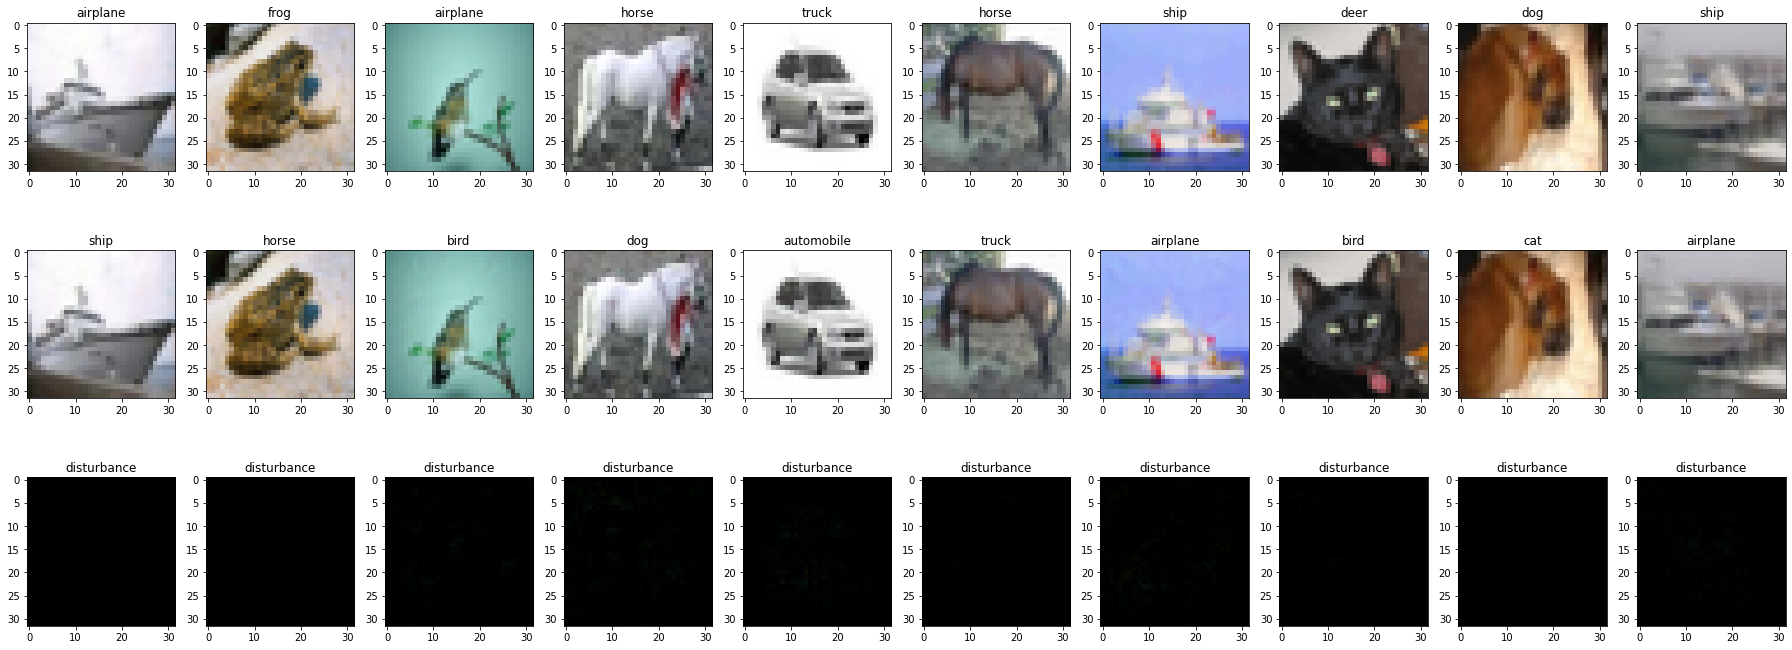

In [36]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

##### 2.1.2.1.2 Test the effect of the attack with 100 random examples

In [37]:
x_test_adv = attack.generate(x=x_test_100)

In [38]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Total use 100 examples for testing
Accuracy on benign test examples: 21.0%


#### 2.1.2.2 C&W L1

In [39]:
# Initialising the attacker
attack = CarliniL2Method(classifier=classifier)

###### 2.1.2.2.1 Use 10 samples for showing difference and Effects

In [40]:
x_test_adv = attack.generate(x=x_test_10)

C&W L_2:   0%|          | 0/10 [00:00<?, ?it/s]

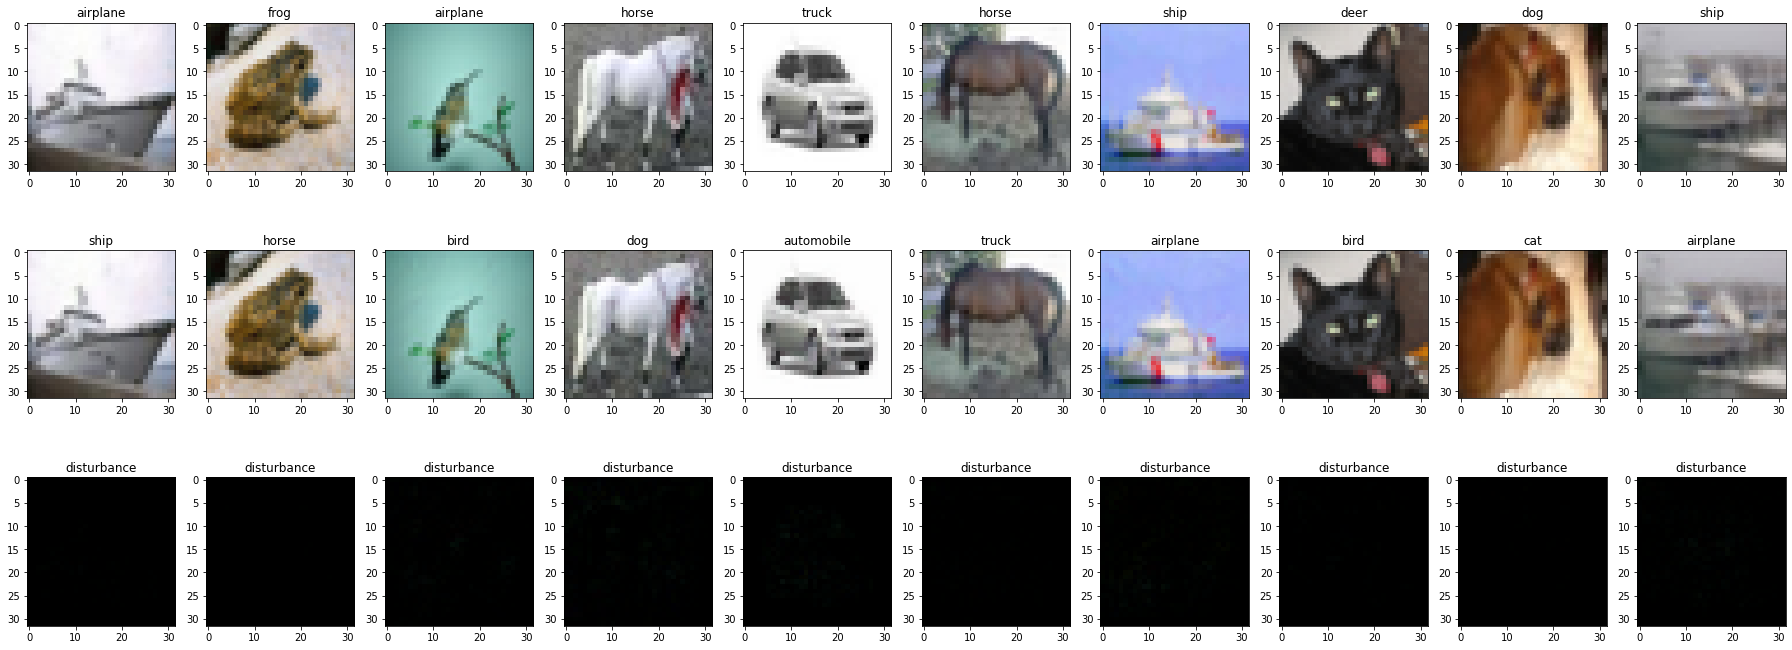

In [41]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

###### 2.1.2.2.2 Test the effect of the attack with 100 random examples

In [42]:
x_test_adv = attack.generate(x=x_test_100)

C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Total use 100 examples for testing
Accuracy on benign test examples: 22.0%


#### 2.1.2.3 C&W Infinite

In [44]:
# Initialising the attacker
attack = CarliniLInfMethod(classifier=classifier)

###### 2.1.2.3.1 Use 10 samples for showing difference and Effects

In [45]:
x_test_adv = attack.generate(x=x_test_10)

C&W L_inf:   0%|          | 0/10 [00:00<?, ?it/s]

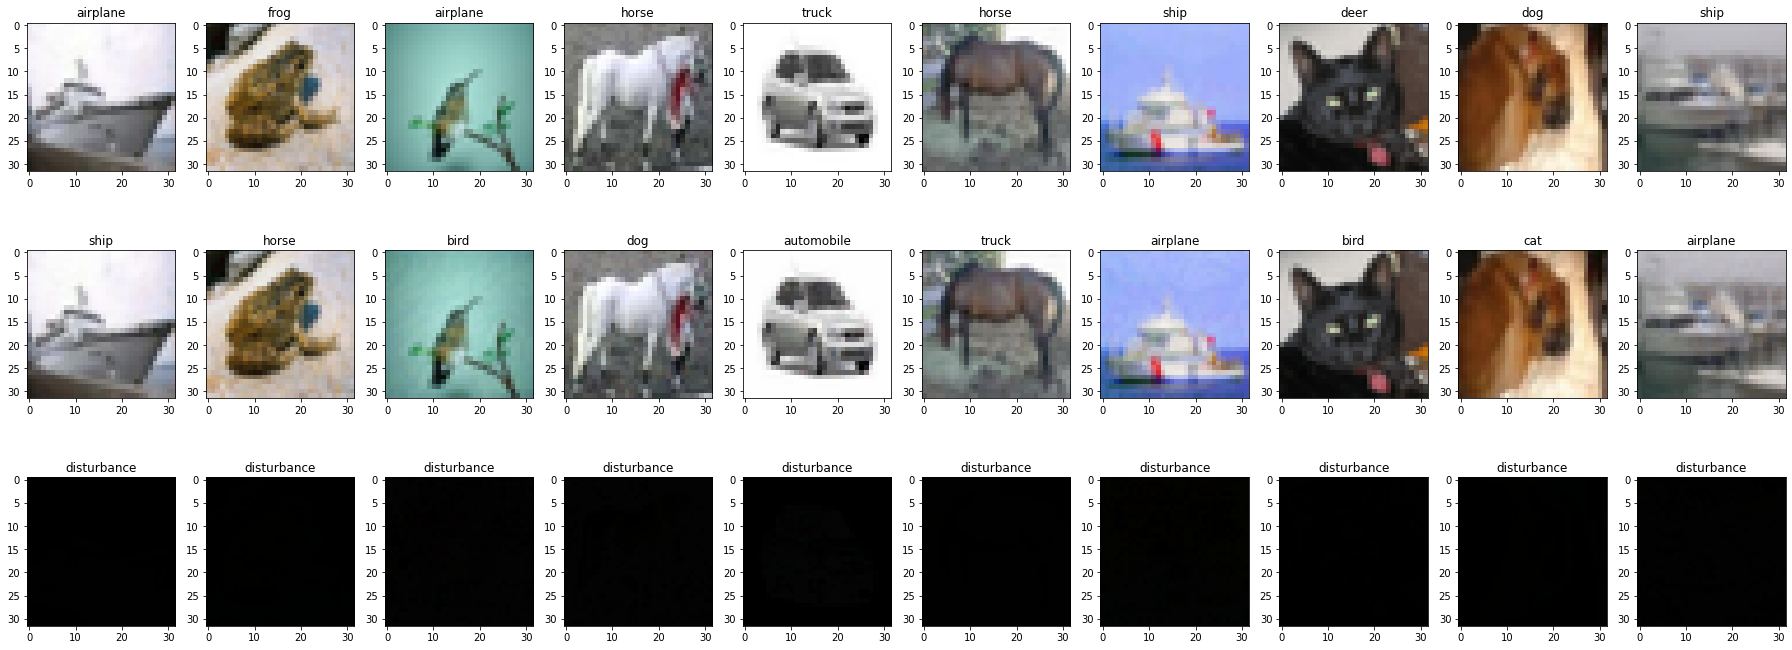

In [46]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

###### 2.1.2.3.2 Test the effect of the attack with 100 random examples

In [47]:
x_test_adv = attack.generate(x=x_test_100)

C&W L_inf:   0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Total use 100 examples for testing
Accuracy on benign test examples: 20.0%
